# Summary
The final goal is to build a model that is able to impute the entire set of leads. That is, it is 
$$f:R^{12}->R^{12}$$
Therefore, we have to modify the model from 3.0 and before. In this notebook I do that.  


**In this notebook we explored models and dataloaders.**
**TO DO:** 
- It seems that the vanilla transformer model can handle 12 leads. Maybe we want to embedd them before feeding them to the transformer, as is being done usually in the fusion literature.
- We finished to create the dataloader that would return 12 leads. Now the only thing left to do is to add a scrutinization mechanism to it. Before you can proceed, you have to unpack the MIT stress data given in the next notebook, notebook number 5.

In [17]:
config = {
    # general
    'seed': 123,
    'data_folder_path': './data/processed/',
    'lead1': "LI",
    'lead2': "LII",
    # training
    'batch_size': 32,
    'n_epochs': 10,
    # architecture - to be changed later and pushed out towards tuning,
    'init_token': None,
    'input_dimension': 12,
    'output_dimension': 12,              # these should remain constant,
    'hidden_dimmension':  128,           # d_model (int) – the number of expected features in the input (required)???,
    'attention_heads': None,             # number of attention heads, if None then d_model//64,
    'encoder_number_of_layers': 2,
    'decoder_number_of_layers': 2,
    'dropout': 0.3,
    'clip': 1,
    'window': 500 ,
    'positional_encodings': False,
    'stride': 0.25,
    'n_iters':  500,                      # plot intermediate results on validation every <n_iters> steps,
    'num_plots': 5,
    'model_type': "encoder"
}


In [20]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from modeling.Transformer import *

class TSTransformerEncoder(nn.Module):

    def __init__(self, input_dimension, output_dimension, hidden_dimmension,
                 attention_heads, encoder_number_of_layers,  
                 positional_encodings, dropout, dim_feedforward=512, activation='gelu', **kwargs):
        super(TSTransformerEncoder, self).__init__()

        self.project_input = nn.Linear(input_dimension, hidden_dimmension)

        self.hidden_dimmension = hidden_dimmension
        if attention_heads is None:
            attention_heads=hidden_dimmension//64
        self.attention_heads = attention_heads
        self.positional_encodings = positional_encodings

        self.encoder = nn.Linear(input_dimension, hidden_dimmension) # using linear projection instead
        self.pos_encoder = PositionalEncoding(hidden_dimmension, dropout)
        
        encoder_layer = TransformerEncoderLayer(hidden_dimmension, self.attention_heads, dim_feedforward, dropout, activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, encoder_number_of_layers)

        self.output_layer = nn.Linear(hidden_dimmension, output_dimension)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.input_dimension = output_dimension

    def forward(self, src,trg_):#, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, seq_length, feat_dim)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        src = self.project_input(src)                                                     # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        print('src', src.shape)
        if self.positional_encodings:                                                   # add positional encoding
            src = self.pos_encoder(src)
                                                         
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        # output = self.transformer_encoder(src, src_key_padding_mask=~padding_masks)     # (seq_length, batch_size, d_model)
        output = self.transformer_encoder(src)     # (seq_length, batch_size, d_model)
        output = self.act(output)                                                       # the output transformer encoder/decoder embeddings don't include non-linearity
        # output = output.permute(1, 0, 2)                                                # (batch_size, seq_length, d_model)
        output = self.dropout1(output)
        # Most probably defining a Linear(d_model,feat_dim) vectorizes the operation over (seq_length, batch_size).
        output = self.output_layer(output)  # (batch_size, seq_length, feat_dim)
        return output

In [21]:
model = TSTransformerEncoder(**config) # .to(device) # we're only experimenting, using different devices adds unrequired complexity


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [25]:
x1 = torch.from_numpy(np.random.uniform(0,1,(500,16,12))).float()
x2 = torch.from_numpy(np.random.uniform(0,1,(500,16,12))).float()
print('input')
print('\tshape:', x1.shape, 'type:', type(x1))
print('output')
trg_ = model(x1,x2)
print('\tshape:', trg_.shape, 'type:', type(trg_))


input
	shape: torch.Size([500, 16, 12]) type: <class 'torch.Tensor'>
output
src torch.Size([500, 16, 128])
	shape: torch.Size([500, 16, 12]) type: <class 'torch.Tensor'>


So it seems that changing the number of channles should suffice. 

# DataLoader
The real problem is creating a DataLoader. It should 
1. Load all the readings of a given person. 
2. Do it for $b$ in $\{batch\}$
3. Draw random number and if it occures then do dome scrutinization

In [26]:
from dataloader.DataLoader import *

In [43]:

class DataGenerator_12leads():
    def __init__(self,
                 data_folder_path:str, # path to relevant folder
                 batch_size:int,       # batch size
                 list_IDs:List[str],   # list of relevat IDs (each ID is given in a <file>_<person> format)
                 shuffle:bool = True   # Whether to shuffle the list of IDs at the end of each epoch.
                 ):
        
        self.data_path = data_folder_path
        self.leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
        self.scaler = MinMaxScaler()
        self.list_IDs = list_IDs
        self.indices = np.arange(len(self.list_IDs))
        self.batch_size = batch_size
        self.shuffle = shuffle

    def _get_sample(self, lead, person, data_folder_path):
        """
        load the relevant <lead> reading .npy file from <data_folder_path>. 
        Inputs:
        - lead:str. The lead we want to load.
        - person:str. The index of the person.
        - data_folder_path:str. The path to the folder when the desired file can be loaded from
        """

        file_name = f'{person.split("_")[0]}_{lead}_{person.split("_")[1]}.npy'
        signal = np.load(data_folder_path+file_name,allow_pickle=True)
        
        # fillna in signal by mean, and take the int of it
        signal[signal!=signal] = int(np.nanmean(signal))

        return signal

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        import random
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    
    def __data_generation(self, list_IDs_temp):
        """
        Get a list of persons IDs and return a batch of X1 and X2 signals.
        """
        data_path = self.data_path

        # Initialization
        X1 = X2 = np.array([[self._get_sample(lead, person_id, data_path) for lead in self.leads] for person_id in list_IDs_temp])
        print('batch_size:', X1.shape)
        return X1, X2
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data using __data_generation'
        # Generate indexes of the batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indices]

        # Generate data
        X1, X2 = self.__data_generation(list_IDs_temp)
        
        # cast to int
        X1=X1.astype(int)
        X2=X2.astype(int)

        # # normalize
        # X1 = self.scaler.fit_transform(X1.T).T
        # X2 = self.scaler.fit_transform(X2.T).T

        return X1, X2



### Compare the two versions of dataloaders


In [44]:
# --------------------------------
# Usage example
# --------------------------------
import pickle
DESTINATION_FOLDER = './data/processed/'
BATCH_SIZE = 4
with open(DESTINATION_FOLDER+"splits.pkl", 'rb') as handle:
    splits = pickle.load(handle)

train_generator = DataGenerator_12leads(
                                data_folder_path=DESTINATION_FOLDER, # path to relevant folder
                                batch_size=BATCH_SIZE,                        # batch size
                                list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                )

X1,X2 = train_generator.__getitem__(0)
print(X1.shape, X2.shape)
X1, X2

batch_size: (4, 12, 5000)
(4, 12, 5000) (4, 12, 5000)


(array([[[   0,   10,  -15, ...,   20,   20,   10],
         [   5,    5,  -34, ...,    5,   15,    5],
         [   5,   -5,  -20, ...,  -15,   -5,   -5],
         ...,
         [ -44,  -44,  -39, ...,    5,    5,   10],
         [ -29,  -24,  -20, ...,   15,   20,   20],
         [  83,   83,   83, ...,   10,   15,   15]],
 
        [[ -59,  -59,  -59, ...,   54,   59,   59],
         [ -68,  -68,  -68, ...,  146,  146,  156],
         [ -10,  -10,  -10, ...,   93,   88,   98],
         ...,
         [ -88,  -88,  -88, ..., -395, -390, -390],
         [ -88,  -88,  -88, ...,  161,  166,  171],
         [-185, -185, -185, ..., -268, -264, -264]],
 
        [[  59,   59,   59, ..., -117,  -59,  -83],
         [  78,   78,   78, ...,  -98,  -68,  -29],
         [  20,   20,   20, ...,   20,  -10,   54],
         ...,
         [ 468,  468,  468, ..., -298, -293, -293],
         [ 429,  429,  429, ..., -410, -400, -405],
         [ -39,  -39,  -39, ..., -254, -239, -249]],
 
        [[ -2

batch (4, 12, 5000)
X1[0] (12, 5000)
X1[0][0] (5000,)


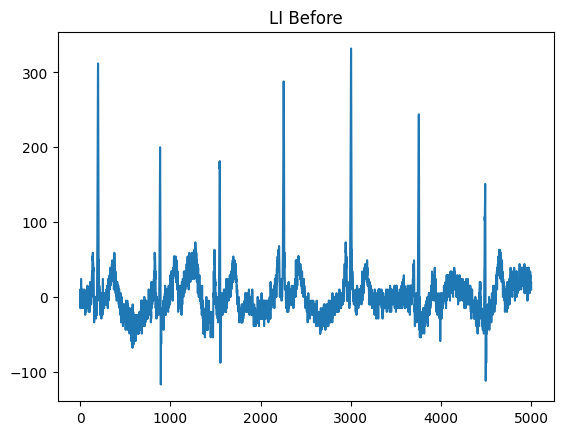

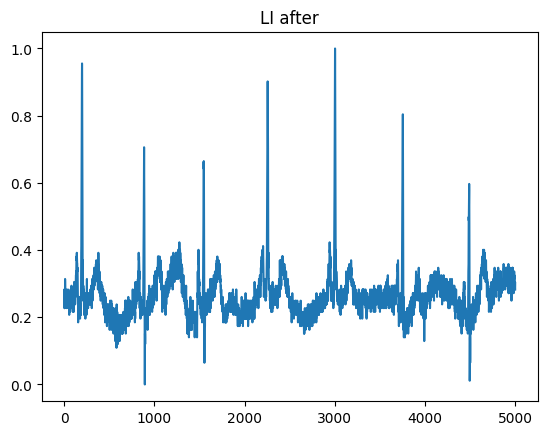

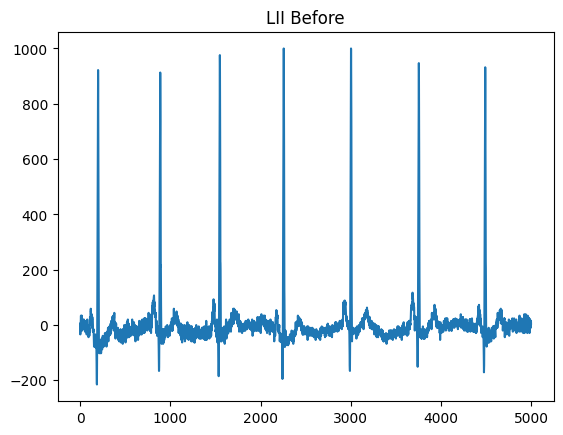

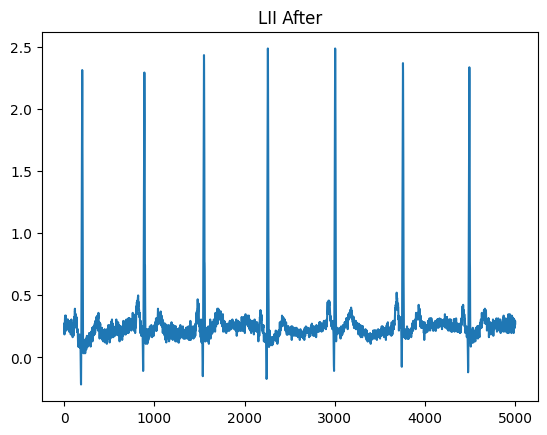

In [62]:
import matplotlib.pylab as plt
print('batch', X1.shape)
print('X1[0]', X1[0].shape)
print('X1[0][0]', X1[0][0].shape)


scaler = MinMaxScaler()

def normalize_12_leads(leads_signals,scaler):
    return [scaler.fit_transform(leads_signals[j].reshape((-1,1))) if j==0 else scaler.transform(leads_signals[j].reshape((-1,1))) for j in range(12)]


plt.plot(X1[0][0])
plt.title('LI Before')
plt.show()

X1_normalized = normalize_12_leads(X1[0],scaler)
plt.plot(X1_normalized[0])
plt.title('LI after')
plt.show()

plt.plot(X1[0][1])
plt.title('LII Before')
plt.show()
plt.plot(X1_normalized[1])
plt.title('LII After')
plt.show()



Adding it into the generator

In [65]:

class DataGenerator_12leads():
    def __init__(self,
                 data_folder_path:str, # path to relevant folder
                 batch_size:int,       # batch size
                 list_IDs:List[str],   # list of relevat IDs (each ID is given in a <file>_<person> format)
                 shuffle:bool = True   # Whether to shuffle the list of IDs at the end of each epoch.
                 ):
        
        self.data_path = data_folder_path
        self.leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
        self.scaler = MinMaxScaler()
        self.list_IDs = list_IDs
        self.indices = np.arange(len(self.list_IDs))
        self.batch_size = batch_size
        self.shuffle = shuffle

    def _get_sample(self, lead, person, data_folder_path):
        """
        load the relevant <lead> reading .npy file from <data_folder_path>. 
        Inputs:
        - lead:str. The lead we want to load.
        - person:str. The index of the person.
        - data_folder_path:str. The path to the folder when the desired file can be loaded from
        """

        file_name = f'{person.split("_")[0]}_{lead}_{person.split("_")[1]}.npy'
        signal = np.load(data_folder_path+file_name,allow_pickle=True)
        
        # fillna in signal by mean, and take the int of it
        signal[signal!=signal] = int(np.nanmean(signal))

        return signal

    def normalize_12_leads(leads_signals,scaler):
        return [scaler.fit_transform(leads_signals[j].reshape((-1,1))) if j==0 else scaler.transform(leads_signals[j].reshape((-1,1))) for j in range(12)]


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        import random
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    
    def __data_generation(self, list_IDs_temp):
        """
        Get a list of persons IDs and return a batch of X1 and X2 signals.
        """
        data_path = self.data_path

        # Initialization
        X1 = np.array([[self._get_sample(lead, person_id, data_path) for lead in self.leads] for person_id in list_IDs_temp])
        print('batch_size:', X1.shape)
        return X1
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data using __data_generation'
        # Generate indexes of the batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indices]

        # Generate data
        X1 = self.__data_generation(list_IDs_temp)
        
        # cast to int
        X1=X1.astype(int)

        # # normalize
        X1 = X2 = np.array([normalize_12_leads(X1[j],self.scaler) for j in range(X1.shape[0])]).squeeze(-1)

        # X1 = self.scaler.fit_transform(X1.T).T
        # X2 = self.scaler.fit_transform(X2.T).T

        return X1, X2



In [66]:
# --------------------------------
# Usage example
# --------------------------------
import pickle
DESTINATION_FOLDER = './data/processed/'
BATCH_SIZE = 4
with open(DESTINATION_FOLDER+"splits.pkl", 'rb') as handle:
    splits = pickle.load(handle)

train_generator = DataGenerator_12leads(
                                data_folder_path=DESTINATION_FOLDER, # path to relevant folder
                                batch_size=BATCH_SIZE,                        # batch size
                                list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                )

X1,X2 = train_generator.__getitem__(0)
print(X1.shape, X2.shape)
X1, X2

batch_size: (4, 12, 5000)
(4, 12, 5000) (4, 12, 5000)


(array([[[ 0.26057906,  0.28285078,  0.22717149, ...,  0.30512249,
           0.30512249,  0.28285078],
         [ 0.27171492,  0.27171492,  0.18485523, ...,  0.27171492,
           0.29398664,  0.27171492],
         [ 0.27171492,  0.24944321,  0.21603563, ...,  0.22717149,
           0.24944321,  0.24944321],
         ...,
         [ 0.16258352,  0.16258352,  0.17371938, ...,  0.27171492,
           0.27171492,  0.28285078],
         [ 0.19599109,  0.20712695,  0.21603563, ...,  0.29398664,
           0.30512249,  0.30512249],
         [ 0.4454343 ,  0.4454343 ,  0.4454343 , ...,  0.28285078,
           0.29398664,  0.29398664]],
 
        [[ 0.24781086,  0.24781086,  0.24781086, ...,  0.34676007,
           0.35113835,  0.35113835],
         [ 0.23992995,  0.23992995,  0.23992995, ...,  0.42732049,
           0.42732049,  0.43607706],
         [ 0.29071804,  0.29071804,  0.29071804, ...,  0.38091068,
           0.3765324 ,  0.38528897],
         ...,
         [ 0.22241681,  0.2224168

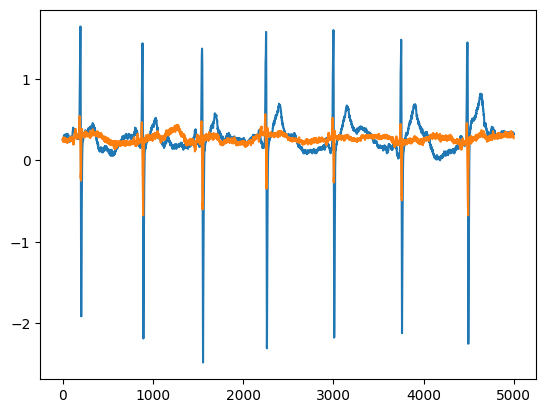

In [130]:
plt.plot(X1[0][8])
plt.plot(X1[0][4])


# Scrutinize some of the signals
- Add gausian noise
- turn off some of the signals (make them a constant of 0)
- Electrode Motion Artifacts (EM)
- Muscle Artifacts (MA)
- Baseline Wander (BW)

## Electrode Motion Artifact

In [131]:
signal = X1[0][8]

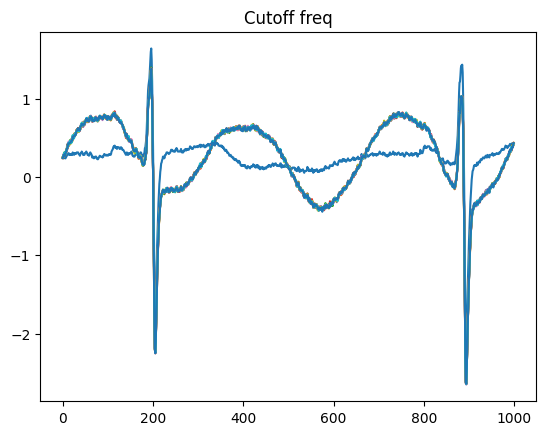

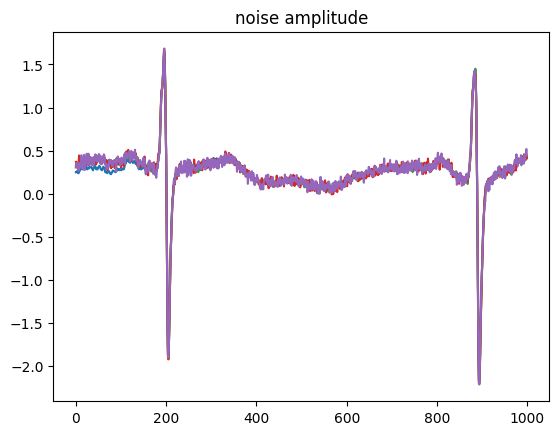

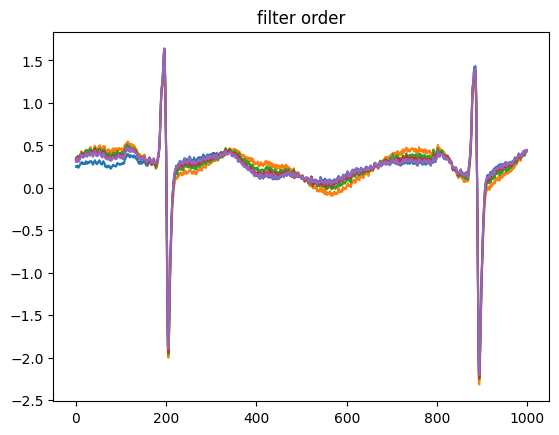

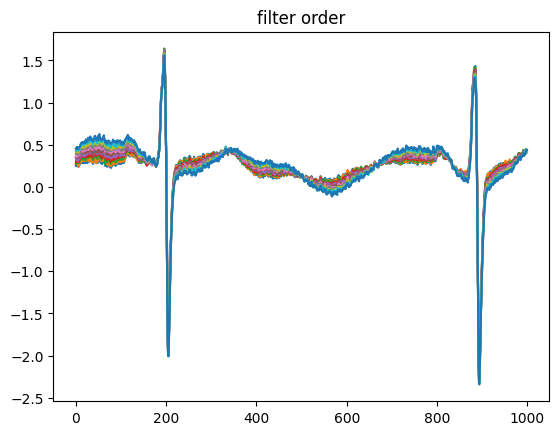

In [133]:
import numpy as np
from scipy.signal import butter, filtfilt

def generate_ma_signal(duration, sampling_rate, ma_amplitude, noise_amplitude=None, filter_order=None, cutoff_freq=None):
    num_samples = int(duration * sampling_rate)
    
    # Generate a sinusoidal wave as the muscle artifact signal
    time = np.arange(num_samples) / sampling_rate
    frequency = 1.5  # Adjust the frequency of the muscle artifact
    ma_signal = ma_amplitude * np.sin(2 * np.pi * frequency * time)
    
    # Filter the MA signal if filter parameters are provided
    if filter_order is not None and cutoff_freq is not None:
        nyquist_freq = 0.5 * sampling_rate
        normalized_cutoff = cutoff_freq / nyquist_freq
        b, a = butter(filter_order, normalized_cutoff, btype='lowpass', analog=False)
        ma_signal = filtfilt(b, a, ma_signal)
    
    # Add noise if noise amplitude is provided
    if noise_amplitude is not None:
        noise = noise_amplitude * np.random.randn(num_samples)
        ma_signal += noise
    
    return ma_signal



plt.plot(signal[:1000])
for j in range(1,11):
    # Example usage
    duration = 10.0  # Duration of the MA signal in seconds
    sampling_rate = 500  # Sampling rate of the MA signal in Hz
    ma_amplitude = 0.5  # Amplitude of the MA signal
    noise_amplitude = 0.01  # Amplitude of the noise signal
    filter_order = 4  # Filter order
    cutoff_freq = j*10.0  # Cutoff frequency in Hz

    ma_signal = generate_ma_signal(duration, sampling_rate, ma_amplitude, noise_amplitude, filter_order, cutoff_freq)

    plt.plot((signal+ma_signal)[:1000])
plt.title('Cutoff freq')
plt.show()


plt.plot(signal[:1000])
for j in range(1,5):
    # Example usage
    duration = 10.0  # Duration of the MA signal in seconds
    sampling_rate = 500  # Sampling rate of the MA signal in Hz
    ma_amplitude = 0.5  # Amplitude of the MA signal
    noise_amplitude = 0.01*j  # Amplitude of the noise signal
    filter_order = 4  # Filter order
    cutoff_freq = 1.0  # Cutoff frequency in Hz

    ma_signal = generate_ma_signal(duration, sampling_rate, ma_amplitude, noise_amplitude, filter_order, cutoff_freq)

    plt.plot((signal+ma_signal)[:1000])
plt.title('noise amplitude')
plt.show()


plt.plot(signal[:1000])
for j in range(1,5):
    # Example usage
    duration = 10.0  # Duration of the MA signal in seconds
    sampling_rate = 500  # Sampling rate of the MA signal in Hz
    ma_amplitude = 0.5  # Amplitude of the MA signal
    noise_amplitude = 0.01  # Amplitude of the noise signal
    filter_order = j  # Filter order
    cutoff_freq = 1.0  # Cutoff frequency in Hz

    ma_signal = generate_ma_signal(duration, sampling_rate, ma_amplitude, noise_amplitude, filter_order, cutoff_freq)

    plt.plot((signal+ma_signal)[:1000])
plt.title('filter order')
plt.show()


plt.plot(signal[:1000])
for j in range(1,11):
    # Example usage
    duration = 10.0  # Duration of the MA signal in seconds
    sampling_rate = 500  # Sampling rate of the MA signal in Hz
    ma_amplitude = 0.1*j  # Amplitude of the MA signal
    noise_amplitude = 0.01  # Amplitude of the noise signal
    filter_order = 2  # Filter order
    cutoff_freq = 1.0  # Cutoff frequency in Hz

    ma_signal = generate_ma_signal(duration, sampling_rate, ma_amplitude, noise_amplitude, filter_order, cutoff_freq)

    plt.plot((signal+ma_signal)[:1000])
plt.title('filter order')
plt.show()


In [125]:
duration = 10.0  # Duration of the MA signal in seconds
sampling_rate = 500  # Sampling rate of the MA signal in Hz
ma_amplitude = 0.5  # Amplitude of the MA signal
noise_amplitude = 0.01  # Amplitude of the noise signal
filter_order = 4  # Filter order
cutoff_freq = j*10.0  # Cutoff frequency in Hz

ma_signal = generate_ma_signal(duration, sampling_rate, ma_amplitude, noise_amplitude, filter_order, cutoff_freq)
ma_signal.shape

(5000,)

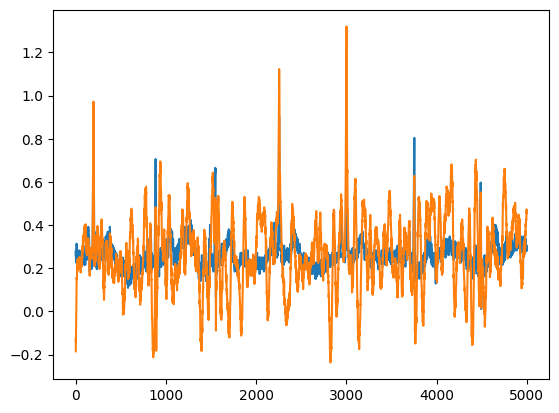

In [88]:
import numpy as np
from scipy.signal import butter, filtfilt

signal = X1[0][0]


def add_ema_to_ecg(ecg_signal, ema_signal, ema_amplitude, filter_order, cutoff_freq):
    # Scale the EMA signal amplitude
    scaled_ema_signal = ema_amplitude * ema_signal

    # Filter the EMA signal
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = butter_lowpass(filter_order, normalized_cutoff)
    filtered_ema_signal = filtfilt(b, a, scaled_ema_signal)

    # Add filtered EMA signal to ECG signal
    ecg_with_ema = ecg_signal + filtered_ema_signal

    return ecg_with_ema

def butter_lowpass(order, cutoff_freq):
    nyquist_freq = 0.5
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normalized_cutoff, btype='lowpass', analog=False)
    return b, a

# Example usage
# Assuming the original ECG signal is stored in the 'signal' variable as a numpy array

# Generate EMA signal (random noise for demonstration purposes)
duration = len(signal)  # Same duration as ECG signal
sampling_rate = 1000  # Same sampling rate as ECG signal
ema_signal = np.random.randn(duration)  # Replace with your own EMA signal generation method

# Specify EMA amplitude (adjust as needed)
ema_amplitude = 0.8  # Adjust as per desired artifact intensity

# Filter parameters
filter_order = 4  # Filter order (adjust as needed)
cutoff_freq = 10.0  # Cutoff frequency (adjust as needed)

# Add EMA to ECG signal
ecg_with_ema = add_ema_to_ecg(signal, ema_signal, ema_amplitude, filter_order, cutoff_freq)

plt.plot(signal)
plt.plot(ecg_with_ema)


In [ ]:

class DataGenerator_12leads():
    def __init__(self,
                 data_folder_path:str, # path to relevant folder
                 batch_size:int,       # batch size
                 list_IDs:List[str],   # list of relevat IDs (each ID is given in a <file>_<person> format)
                 shuffle:bool = True   # Whether to shuffle the list of IDs at the end of each epoch.
                 ):
        
        self.data_path = data_folder_path
        self.leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
        self.scaler = MinMaxScaler()
        self.list_IDs = list_IDs
        self.indices = np.arange(len(self.list_IDs))
        self.batch_size = batch_size
        self.shuffle = shuffle

    def _get_sample(self, lead, person, data_folder_path):
        """
        load the relevant <lead> reading .npy file from <data_folder_path>. 
        Inputs:
        - lead:str. The lead we want to load.
        - person:str. The index of the person.
        - data_folder_path:str. The path to the folder when the desired file can be loaded from
        """

        file_name = f'{person.split("_")[0]}_{lead}_{person.split("_")[1]}.npy'
        signal = np.load(data_folder_path+file_name,allow_pickle=True)
        
        # fillna in signal by mean, and take the int of it
        signal[signal!=signal] = int(np.nanmean(signal))

        return signal

    def normalize_12_leads(leads_signals,scaler):
        return [scaler.fit_transform(leads_signals[j].reshape((-1,1))) if j==0 else scaler.transform(leads_signals[j].reshape((-1,1))) for j in range(12)]


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        import random
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    
    def __data_generation(self, list_IDs_temp):
        """
        Get a list of persons IDs and return a batch of X1 and X2 signals.
        """
        data_path = self.data_path

        # Initialization
        X1 = np.array([[self._get_sample(lead, person_id, data_path) for lead in self.leads] for person_id in list_IDs_temp])
        print('batch_size:', X1.shape)
        return X1
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data using __data_generation'
        # Generate indexes of the batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indices]

        # Generate data
        X1 = self.__data_generation(list_IDs_temp)
        
        # cast to int
        X1=X1.astype(int)

        # # normalize
        X1 = X2 = np.array([normalize_12_leads(X1[j],self.scaler) for j in range(X1.shape[0])]).squeeze(-1)

        # X1 = self.scaler.fit_transform(X1.T).T
        # X2 = self.scaler.fit_transform(X2.T).T

        return X1, X2



# CNN + transformer? TBA